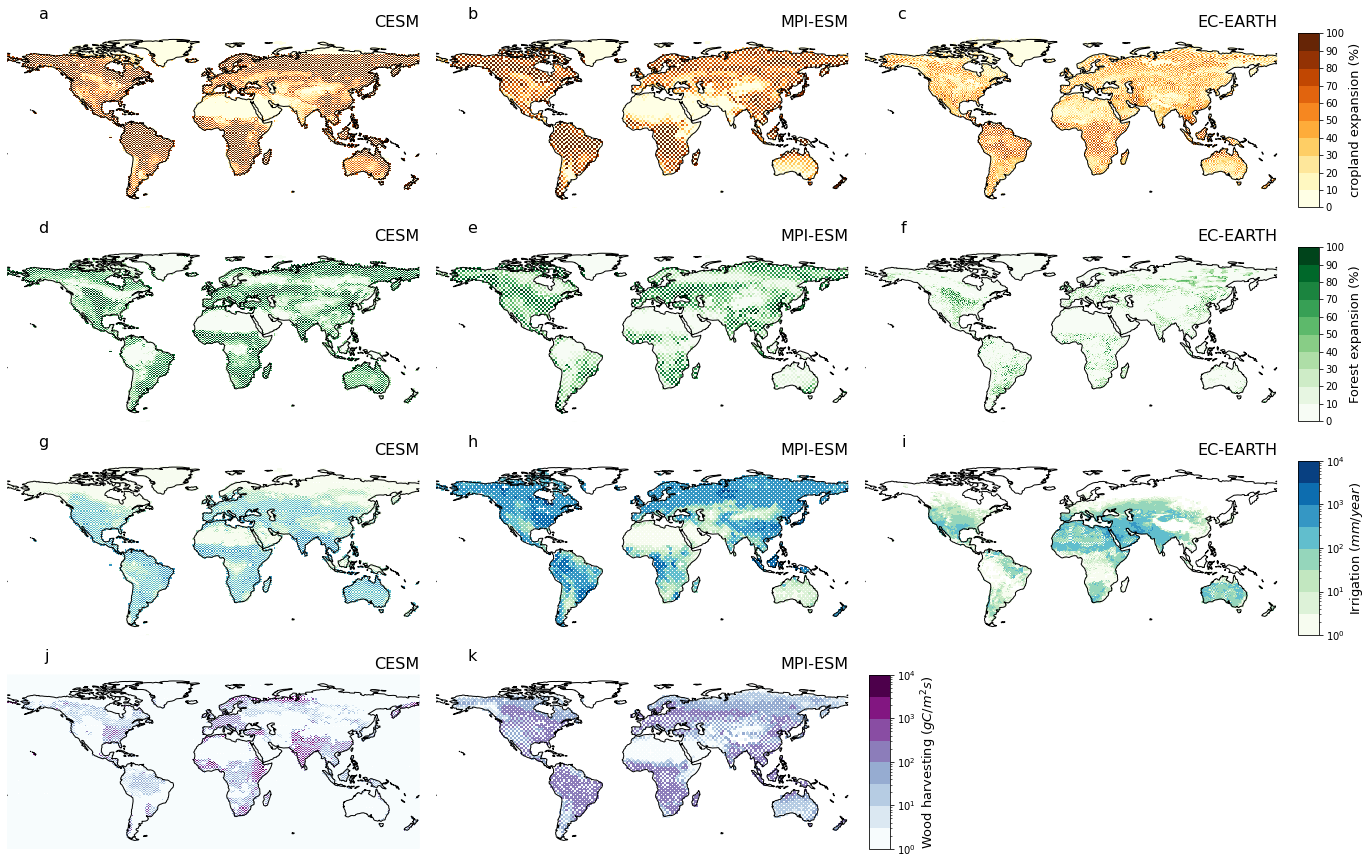

In [2]:
#TO DO
#change figsize and fig.tight layout so it looks nicer

from __future__ import print_function
import sys
import os
from getpass import getuser
import string
import subprocess
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import netCDF4 as netcdf4
import xarray as xr
import pandas
#import regionmask
import cartopy.crs as ccrs
#from IPython.display import display, Math, Latex
import warnings
import dask
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import transforms
from mask import mask_data
from func_utils import *
import mplotutils as mpu
from matplotlib.colors import LogNorm

plt.rcParams['figure.figsize'] = [18, 12]
matplotlib.rc('axes',edgecolor='none')

outdir = '/scratch/leuven/projects/lt1_2020_es_pilot/project_output/bclimate/sdeherto/lamaclima_wp1/LU_maps/'
procdir=outdir
os.chdir(procdir)

model='cesm'

fn_CTL = 'surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr2014_noWH.nc'
fn_CROP = 'surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr2014_CROP_nourb.nc'
fn_FRST = 'surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr2014_FRST_nourb.nc'
fn_WH='surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr2014_HARV_nourb.nc'
outdir_LU = outdir
fn_CTL_mpi='/land_cover_fractions/land-cover-fractions_mpiesm_ctl-simulation.nc'
fn_CROP_mpi='/land_cover_fractions/land-cover-fractions_mpiesm_crop-simulation.nc'
fn_FRST_mpi='/land_cover_fractions/land-cover-fractions_mpiesm_frst-simulation.nc'

fn_CTL_ec='Emon_Land_40yr.nc'
fn_CROP_ec='CROP_Emon_Land_40yr.nc'
#fn_FRST_ec='FRST_Emon_Land_40yr.nc'
fn_FRST_ec='FRST_Emon_Land_160yr.nc'
fn_IRR_ec='IRRI_Emon_Land_40yr.nc'
i=0
fn_list=[fn_CTL,fn_CROP,fn_FRST]
case_list=['crop-ctl','frst-ctl']
# define colormap (more info on colormaps: https://matplotlib.org/users/colormaps.html)
ds_cesm=xr.open_dataset(outdir+'AREA_CESM.nc')
ds_CTL = xr.open_dataset(outdir_LU+fn_CTL)
da=ds_cesm.area
da_natveg_CTL=ds_CTL['PCT_NATVEG']
da_natpft_CTL=ds_CTL['PCT_NAT_PFT']
da_forest_CTL=da_natveg_CTL[:]/100-(da_natveg_CTL[:]/(100)*(da_natpft_CTL[0,:,:]+np.sum(da_natpft_CTL[9:,:,:],axis=0))/(100))
#da_forest_CTL=xr.where(da_forest<0.01,np.nan,da_forest)
da_crop_CTL=ds_CTL['PCT_CROP']/100

ds_CTL_mpi = xr.open_dataset(outdir_LU+fn_CTL_mpi)
da_forest_CTL_mpi=ds_CTL_mpi['ExTropDecidTrees']+ds_CTL_mpi['ExTropEvergTrees']+ds_CTL_mpi['TropDecidTrees']+ds_CTL_mpi['TropEvergTrees']
da_crop_CTL_mpi=ds_CTL_mpi['C3Crop']+ds_CTL_mpi['C4Crop']

ds_CTL_ec = xr.open_dataset(outdir_LU+fn_CTL_ec)
da_forest_CTL_ec=ds_CTL_ec['treeFracNdlEvg']+ds_CTL_ec['treeFracNdlDcd']+ds_CTL_ec['treeFracBdlEvg']+ds_CTL_ec['treeFracBdlDcd']
da_crop_CTL_ec=ds_CTL_ec['cropFracC3']+ds_CTL_ec['cropFracC4']
da_forest_CTL_ec=da_forest_CTL_ec.max('time')
da_crop_CTL_ec=da_crop_CTL_ec.max('time')

ds_CROP = xr.open_dataset(outdir_LU+fn_CROP)
da_crop_CROP=ds_CROP['PCT_CROP']/100
ds_CROP_mpi = xr.open_dataset(outdir_LU+fn_CROP_mpi)
da_crop_CROP_mpi=ds_CROP_mpi['C3Crop']+ds_CROP_mpi['C4Crop']
da_crop_CROP_mpi=da_crop_CROP_mpi.sortby(["lat"], ascending=False)
da_crop_CROP_mpi,da_crop_CTL_mpi = xr.align(da_crop_CROP_mpi, da_crop_CTL_mpi, join="override")
ds_CROP_ec = xr.open_dataset(outdir_LU+fn_CROP_ec)
da_crop_CROP_ec=ds_CROP_ec['cropFracC3']+ds_CROP_ec['cropFracC4']
da_crop_CROP_ec=da_crop_CROP_ec.max('time')


ds_FRST = xr.open_dataset(outdir_LU+fn_FRST)
da_natveg_FRST=ds_FRST['PCT_NATVEG']
da_natpft_FRST=ds_FRST['PCT_NAT_PFT']
da_forest_FRST=da_natveg_FRST[:]/100-(da_natveg_FRST[:]/(100)*(da_natpft_FRST[0,:,:]+np.sum(da_natpft_FRST[9:,:,:],axis=0))/(100))
ds_FRST_mpi = xr.open_dataset(outdir_LU+fn_FRST_mpi)
da_forest_FRST_mpi=ds_FRST_mpi['ExTropDecidTrees']+ds_FRST_mpi['ExTropEvergTrees']+ds_FRST_mpi['TropDecidTrees']+ds_FRST_mpi['TropEvergTrees']
ds_FRST_ec = xr.open_dataset(outdir_LU+fn_FRST_ec)
da_forest_FRST_ec=ds_FRST_ec['treeFracNdlEvg']+ds_FRST_ec['treeFracNdlDcd']+ds_FRST_ec['treeFracBdlEvg']+ds_FRST_ec['treeFracBdlDcd']
da_forest_FRST_ec=da_forest_FRST_ec.max('time')

#read irrig files
ds_IRR=xr.open_dataset('/scratch/leuven/projects/lt1_2020_es_pilot/project_output/bclimate/sdeherto/cesm/work/postprocessing/signals_seperated/QIRRIG/QIRRIG_irr-ctl_cesm_ensmean_signal-separated.nc')
da_irr_crop=ds_IRR['QIRRIG'].mean('time')*31536000
da_irr_crop=mask_data(da_irr_crop,'irr-crop','cesm','lnd')
irr_lims=[da_irr_crop.min()*31536000,da_irr_crop.max()*31536000]
da_irr_crop=mask_data(da_irr_crop,'irr-crop','cesm','lnd')
ds_irr_mpi=xr.open_dataset('/scratch/leuven/projects/lt1_2020_es_pilot/project_output/bclimate/sdeherto/cesm/work/postprocessing/signals_seperated/irr-crop/Lmon/irrigation_flux/irrigation_flux_irr-crop_mpiesm_ensmean_signal-separated.nc')
da_irr_crop_mpi=ds_irr_mpi['irrigation_flux'].mean('time')*31536000
ds_irr_ec = xr.open_dataset(outdir_LU+fn_IRR_ec)
da_irr_crop_ec=ds_irr_ec['irrLut'].mean('time').sum('landuse')*31536000


da=ds_cesm.area
da_crop_ctl=da
ds_cesm=xr.open_dataset(outdir+'AREA_CESM.nc')
da1=ds_cesm.area
da_frst_ctl=da1
da_crop_ctl[:]=(da_crop_CROP-da_crop_CTL)*100
da_crop_ctl=mask_data(da_crop_ctl,'crop-ctl','cesm','lnd')
da_frst_ctl[:]=(da_forest_FRST-da_forest_CTL)*100
da_frst_ctl=mask_data(da_frst_ctl,'frst-ctl','cesm','lnd')
da_crop_ctl_mpi=(da_crop_CROP_mpi-da_crop_CTL_mpi)*100
da_frst_ctl_mpi=(da_forest_FRST_mpi-da_forest_CTL_mpi)*100

da_crop_ctl_ec=(da_crop_CROP_ec-da_crop_CTL_ec)
da_frst_ctl_ec=(da_forest_FRST_ec-da_forest_CTL_ec)
ds_mask = xr.open_dataset(outdir+'remapped_ec_mask.nc')
da_mask=ds_mask['mask']

da_crop_ctl_ec, da_mask = xr.align(da_crop_ctl_ec, da_mask, join="override")
da_crop_ctl_ec=xr.where(da_mask>0.5,da_crop_ctl_ec,np.nan)
da_frst_ctl_ec, da_mask = xr.align(da_frst_ctl_ec, da_mask, join="override")
da_frst_ctl_ec=xr.where(da_mask>0.5,da_frst_ctl_ec,np.nan)
#da_frst_ctl_ec=mask_data(da_frst_ctl_ec,'frst-ctl','ecearth','lnd')
#da_crop_ctl_ec=mask_data(da_crop_ctl_ec,'crop-ctl','ecearth','lnd')

da_crop_ctl_ec['lon']=da_crop_ctl_ec['lon'].where(da_crop_ctl_ec['lon']<180,da_crop_ctl_ec['lon']-360)
da_frst_ctl_ec['lon']=da_frst_ctl_ec['lon'].where(da_frst_ctl_ec['lon']<180,da_frst_ctl_ec['lon']-360)
da_crop_ctl_ec=da_crop_ctl_ec.sortby('lon')
da_frst_ctl_ec=da_frst_ctl_ec.sortby('lon')

#read WH 
ds_WH = xr.open_dataset(outdir_LU+fn_WH)
da2=ds_cesm.area
da_harv_frst=da2
da_harv_frst[:]=ds_WH['CONST_HARVEST_SH1']+ds_WH['CONST_HARVEST_VH1']+ds_WH['CONST_HARVEST_SH2']+ds_WH['CONST_HARVEST_VH2']+ds_WH['CONST_HARVEST_SH3']
lims_harv=[da_harv_frst.min(),da_harv_frst.max()] #units gC/(m2yr)
da_harv_frst=mask_data(da_harv_frst,'harv-frst','cesm','lnd')

ds_WH_mpi=xr.open_dataset('/scratch/leuven/projects/lt1_2020_es_pilot/project_output/bclimate/sdeherto/cesm/work/postprocessing/signals_seperated/harv-frst/Lmon/fCropharv/fCropharv_harv-frst_mpiesm_ymonensmean_signal-separated.nc')
da_harv_frst_mpi=ds_WH_mpi['fCropharv'].mean('time')*1000* 31536000 ##units kg/(m2s)
lims_harv_mpi=[da_harv_frst_mpi.min(),da_harv_frst_mpi.max()] #units gC/(m2yr)

fig = plt.figure()
gs = fig.add_gridspec(4,3)
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())

#cmap, norm = mpu.from_levels_and_cmap(levels, 'RdBu_r', extend='both')
cmap = 'YlOrBr'# define colorbar label (including unit!)
cbar_label = 'cropland expansion'

# initiate the figure 
ax.coastlines()
h=da_crop_ctl.plot(ax=ax, cmap=plt.cm.get_cmap(cmap, 10), vmin=0, vmax=100, add_colorbar=False)  
ax.set_title('CESM',loc='right',fontsize=16)
#ax.set_aspect('auto')
ax.set_extent([-180, 180, -63, 89], ccrs.PlateCarree())
label='a'
ax.text(0.1, 1.15, label, transform=ax.transAxes,fontsize=16, va='top', ha='right')
ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())

#cmap, norm = mpu.from_levels_and_cmap(levels, 'RdBu_r', extend='both')
cmap = 'YlOrBr'# define colorbar label (including unit!)
cbar_label = 'cropland expansion (%)'
# initiate the figure 
ax.coastlines()
h=da_crop_ctl_mpi.plot(ax=ax, cmap=plt.cm.get_cmap(cmap, 10), vmin=0, vmax=100, add_colorbar=False)  
#cbar = mpu.colorbar(h, ax1=ax, shift=0., size=0.05, extendfrac=0.1, extend='neither',ticks=[0, 10, 20,30,40,50,60,70,80,90,100],orientation='vertical',label=cbar_label)
#cbar.outline.set_edgecolor('black')
#cbar.set_label(cbar_label, size=13)
#cbar = mpu.colorbar(h, ax1=ax, shift=0.2, size=0.05, extendfrac=0.1, extend='neither',orientation='vertical',label=cbar_label)
ax.set_title('MPI-ESM',loc='right',fontsize=16)
#ax.set_aspect('auto')
ax.set_extent([-180, 180, -63, 89], ccrs.PlateCarree())
ax_old=ax
label='b'
ax.text(0.1, 1.15, label, transform=ax.transAxes,fontsize=16, va='top', ha='right')

ax = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree())

#cmap, norm = mpu.from_levels_and_cmap(levels, 'RdBu_r', extend='both')
cmap = 'YlOrBr'# define colorbar label (including unit!)
cbar_label = 'cropland expansion (%)'
# initiate the figure 
ax.coastlines()
h=da_crop_ctl_ec.plot(ax=ax, cmap=plt.cm.get_cmap(cmap, 10), vmin=0, vmax=100, add_colorbar=False)  
cbar = mpu.colorbar(h, ax1=ax, shift=0., size=0.05, extendfrac=0.1, extend='neither',ticks=[0, 10, 20,30,40,50,60,70,80,90,100],orientation='vertical',label=cbar_label)
cbar.outline.set_edgecolor('black')
cbar.set_label(cbar_label, size=13)
#cbar = mpu.colorbar(h, ax1=ax, shift=0.2, size=0.05, extendfrac=0.1, extend='neither',orientation='vertical',label=cbar_label)
ax.set_title('EC-EARTH',loc='right',fontsize=16)
#ax.set_aspect('auto')
ax.set_extent([-180, 180, -63, 89], ccrs.PlateCarree())
ax_old=ax
label='c'
ax.text(0.1, 1.15, label, transform=ax.transAxes,fontsize=16, va='top', ha='right')
#cmap, norm = mpu.from_levels_and_cmap(levels, 'RdBu_r', extend='both')

ax = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree())

cmap = 'Greens'# define colorbar label (including unit!)
cbar_label = 'Forest expansion'
# initiate the figure 
ax.coastlines()
h=da_frst_ctl.plot(ax=ax, cmap=plt.cm.get_cmap(cmap, 10), vmin=0, vmax=100, add_colorbar=False)  
ax.set_title('CESM',loc='right',fontsize=16)
#ax.set_aspect('auto')
ax.set_extent([-180, 180, -63, 89], ccrs.PlateCarree())
#plt.savefig(outdir + '/'+ case+ '_fraction_forest_map_cesm.png', dpi=300)
#plt.show()
label='d'
ax.text(0.1, 1.15, label, transform=ax.transAxes,fontsize=16, va='top', ha='right')
ax = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree())

#cmap, norm = mpu.from_levels_and_cmap(levels, 'RdBu_r', extend='both')
cmap = 'Greens'# define colorbar label (including unit!)
cbar_label = 'Forest expansion (%)'
# initiate the figure 
ax.coastlines()
h=da_frst_ctl_mpi.plot(ax=ax, cmap=plt.cm.get_cmap(cmap, 10), vmin=0, vmax=100, add_colorbar=False)  
#cbar = mpu.colorbar(h, ax1=ax, shift=0., size=0.05, extendfrac=0.1, extend='neither',ticks=[0, 10, 20,30,40,50,60,70,80,90,100],orientation='vertical',label=cbar_label)
#cbar.outline.set_edgecolor('black')
#cbar.set_label(cbar_label, size=13)
#cbar.set_yticks([0, 10, 20,30,40,50,60,70,80,90,100])
ax.set_title('MPI-ESM',loc='right',fontsize=16)
#ax.set_aspect('auto')
ax.set_extent([-180, 180, -63, 89], ccrs.PlateCarree())
#plt.savefig(outdir + '/'+ case+ '_fraction_forest_map_cesm.png', dpi=300)
#plt.show()
label='e'
ax.text(0.1, 1.15, label, transform=ax.transAxes,fontsize=16, va='top', ha='right')

ax = fig.add_subplot(gs[1,2], projection=ccrs.PlateCarree())

#cmap, norm = mpu.from_levels_and_cmap(levels, 'RdBu_r', extend='both')
cmap = 'Greens'# define colorbar label (including unit!)
cbar_label = 'Forest expansion (%)'
# initiate the figure 
ax.coastlines()
h=da_frst_ctl_ec.plot(ax=ax, cmap=plt.cm.get_cmap(cmap, 10), vmin=0, vmax=100, add_colorbar=False)  
cbar = mpu.colorbar(h, ax1=ax, shift=0., size=0.05, extendfrac=0.1, extend='neither',ticks=[0, 10, 20,30,40,50,60,70,80,90,100],orientation='vertical',label=cbar_label)
cbar.outline.set_edgecolor('black')
cbar.set_label(cbar_label, size=13)
#cbar.set_yticks([0, 10, 20,30,40,50,60,70,80,90,100])
ax.set_title('EC-EARTH',loc='right',fontsize=16)
#ax.set_aspect('auto')
ax.set_extent([-180, 180, -63, 89], ccrs.PlateCarree())
#plt.savefig(outdir + '/'+ case+ '_fraction_forest_map_cesm.png', dpi=300)
#plt.show()
label='f'
ax.text(0.1, 1.15, label, transform=ax.transAxes,fontsize=16, va='top', ha='right')


ax = fig.add_subplot(gs[2,0], projection=ccrs.PlateCarree())
ds_checkers=xr.open_dataset('/scratch/leuven/projects/lt1_2020_es_pilot/project_output/bclimate/sdeherto/lamaclima_wp1/preprocessing/checkerboards_CESMgrid_masked.nc')
da_checkers=ds_checkers['chessboard_pattern']
da_irr_crop, da_checkers = xr.align(da_irr_crop, da_checkers, join="override")
da_irr_crop=da_irr_crop.where(da_checkers==1, 1)
da_irr_crop=mask_data(da_irr_crop,'irr-crop','cesm','lnd')
#cmap, norm = mpu.from_levels_and_cmap(levels, 'RdBu_r', extend='both')
cmap = 'GnBu'# define colorbar label (including unit!)
cbar_label = 'Irrigation'
# initiate the figure 
ax.coastlines()
#vmax=2.5*10**(-5)*31536000
h=da_irr_crop.plot(ax=ax, cmap=plt.cm.get_cmap(cmap, 8), vmin=1, vmax=10000,extend='max', add_colorbar=False,norm=LogNorm())  
ax.set_title('CESM',loc='right',fontsize=16)
#ax.set_aspect('auto')
ax.set_extent([-180, 180, -63, 89], ccrs.PlateCarree())
label='g'
ax.text(0.1, 1.15, label, transform=ax.transAxes,fontsize=16, va='top', ha='right')
#plt.show()

ax = fig.add_subplot(gs[2,1], projection=ccrs.PlateCarree())

#cmap, norm = mpu.from_levels_and_cmap(levels, 'RdBu_r', extend='both')
cmap = 'GnBu'# define colorbar label (including unit!)
cbar_label = 'Irrigation ($mm/year$)'
# initiate the figure Blues
ax.coastlines()
h=da_irr_crop_mpi.plot(ax=ax, cmap=plt.cm.get_cmap(cmap, 8), vmin=1, vmax=10000,extend='max', add_colorbar=False,norm=LogNorm())  

#cbar   = fig.colorbar(h, ax=ax, cmap=cmap,spacing='uniform',orientation='vertical',label = cbar_label)
ax.set_title('MPI-ESM',loc='right',fontsize=16)
#ax.set_aspect('auto')
ax.set_extent([-180, 180, -63, 89], ccrs.PlateCarree())
label='h'
ax.text(0.1, 1.15, label, transform=ax.transAxes,fontsize=16, va='top', ha='right')

ax = fig.add_subplot(gs[2,2], projection=ccrs.PlateCarree())

#cmap, norm = mpu.from_levels_and_cmap(levels, 'RdBu_r', extend='both')
cmap = 'GnBu'# define colorbar label (including unit!)
cbar_label = 'Irrigation ($mm/year$)'
# initiate the figure Blues
ax.coastlines()
h=da_irr_crop_ec.plot(ax=ax, cmap=plt.cm.get_cmap(cmap, 8), vmin=1, vmax=10000,extend='max', add_colorbar=False,norm=LogNorm())  
cbar = mpu.colorbar(h, ax1=ax, shift=0., size=0.05, extendfrac=0.1, extend='neither',orientation='vertical',label=cbar_label)
cbar.outline.set_edgecolor('black')
cbar.set_label(cbar_label, size=13)

#cbar   = fig.colorbar(h, ax=ax, cmap=cmap,spacing='uniform',orientation='vertical',label = cbar_label)
ax.set_title('EC-EARTH',loc='right',fontsize=16)
#ax.set_aspect('auto')
ax.set_extent([-180, 180, -63, 89], ccrs.PlateCarree())
label='i'
ax.text(0.1, 1.15, label, transform=ax.transAxes,fontsize=16, va='top', ha='right')


ax = fig.add_subplot(gs[3,0], projection=ccrs.PlateCarree())

da_harv_frst, da_checkers = xr.align(da_harv_frst, da_checkers, join="override")
da_harv_frst=da_harv_frst.where(da_checkers==1, 1)
#cmap, norm = mpu.from_levels_and_cmap(levels, 'RdBu_r', extend='both')
cmap = 'BuPu'# define colorbar label (including unit!)
cbar_label = 'Wood harvesting ($gC/m^{2}s$))'
# initiate the figure 
ax.coastlines()
h=da_harv_frst.plot(ax=ax, cmap=plt.cm.get_cmap(cmap, 8), vmin=1, vmax=10000,extend='max', add_colorbar=False,norm=LogNorm())  
ax.set_title('CESM',loc='right',fontsize=16)
#ax.set_aspect('auto')
ax.set_extent([-180, 180, -63, 89], ccrs.PlateCarree())
#plt.savefig(outdir + '/'+ case+ '_fraction_forest_map_cesm.png', dpi=300)
#plt.show()
label='j'
ax.text(0.1, 1.15, label, transform=ax.transAxes,fontsize=16, va='top', ha='right')
ax = fig.add_subplot(gs[3,1], projection=ccrs.PlateCarree())

#cmap, norm = mpu.from_levels_and_cmap(levels, 'RdBu_r', extend='both')
cmap = 'BuPu'# define colorbar label (including unit!)
cbar_label = 'Wood harvesting ($gC/m^{2}s$)'
# initiate the figure 
ax.coastlines()
h=da_harv_frst_mpi.plot(ax=ax, cmap=plt.cm.get_cmap(cmap, 8), vmin=1, vmax=10000,extend='max', add_colorbar=False,norm=LogNorm())  
cbar = mpu.colorbar(h, ax1=ax, shift=0., size=0.05, extendfrac=0.1, extend='neither',orientation='vertical',label=cbar_label)
cbar.outline.set_edgecolor('black')
cbar.set_label(cbar_label, size=13)
ax.set_title('MPI-ESM',loc='right',fontsize=16)
#ax.set_aspect('auto')
ax.set_extent([-180, 180, -63, 89], ccrs.PlateCarree())
label='k'
ax.text(0.1, 1.15, label, transform=ax.transAxes,fontsize=16, va='top', ha='right')

fig.subplots_adjust(left=0.01, right=0.99,bottom=0., top=0.99,hspace=0., wspace=0.04)

#fig.tight_layout()
plt.savefig(outdir + '/'+ 'landcovermanagament_change_lamaclima_checkers.png', dpi=300)



In [13]:
print(da_crop_ctl_ec.lon)
da_crop_ctl_ec['lon']=da_crop_ctl_ec['lon'].where(da_crop_ctl_ec['lon']<180,da_crop_ctl_ec['lon']-360)
print(da_crop_ctl_ec.lon)


<xarray.DataArray 'lon' (lon: 512)>
array([  0.      ,   0.703125,   1.40625 , ..., 357.890625, 358.59375 ,
       359.296875])
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
<xarray.DataArray 'lon' (lon: 512)>
array([ 0.      ,  0.703125,  1.40625 , ..., -2.109375, -1.40625 , -0.703125])
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... -2.109 -1.406 -0.7031


<xarray.DataArray 'irrLut' (lat: 256, lon: 512)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46


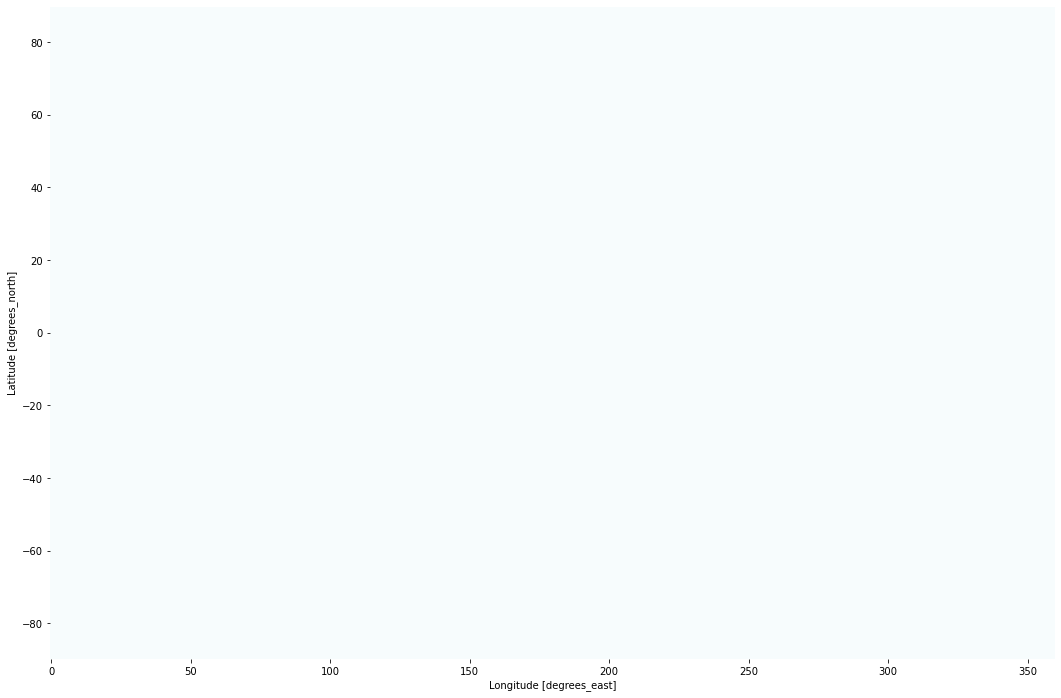

In [14]:
print(da_irr_crop_ec)

f,ax= plt.subplots()
cmap = 'BuPu'# define colorbar label (including unit!)
cbar_label = 'Wood harvesting ($gC/m^{2}s$))'
# initiate the figure 
da_frst_ctl_ec.plot(ax=ax,cmap=plt.cm.get_cmap(cmap, 8), vmin=0, vmax=100,extend='max', add_colorbar=False)  
